# Predictive Model

#### Packages

In [19]:
# file manipualtion
from pathlib import Path
import numpy as np
import pandas as pd
import pickle

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

# balancing dataset
from imblearn.over_sampling import SMOTE

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

# visualistaion
import matplotlib.pyplot as plt
import seaborn as sns

# warning supression
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

#### Directory  creation and file management

In [83]:
# defining the directory to original data
cwd = Path('./')
root_dir = cwd.resolve().parent

original_data_dir = root_dir / 'data'
additional_data_dir = root_dir / 'additional_data'

# creating Path object for plots directory
plots_dir = root_dir / 'plots'
# create new directory for plots directory
Path(plots_dir).mkdir(exist_ok=True)

# list the .csv files for the project
for file in original_data_dir.glob('*.csv'):
    print(file)

/home/jake/Documents/TrafficAccidents/data/vehicles2019.csv
/home/jake/Documents/TrafficAccidents/data/accidents2019.csv
/home/jake/Documents/TrafficAccidents/data/casualties2019.csv


#### Testing classification models

In [3]:
def get_models():
    models = {}
    models['decision_tree'] = DecisionTreeClassifier()
    models['knn'] = KNeighborsClassifier()
    models['logistic_regression'] = LogisticRegression()
    models['bayes'] = MultinomialNB()
    models['rf'] = RandomForestClassifier()
    return models

models = get_models()

models

{'decision_tree': DecisionTreeClassifier(),
 'knn': KNeighborsClassifier(),
 'logistic_regression': LogisticRegression(),
 'bayes': MultinomialNB(),
 'rf': RandomForestClassifier()}

In [4]:
# import cleaned accidents data frame from the pickle file
accidents = pd.read_pickle(additional_data_dir / 'accidents_cleaned.pkl')
vehicles = pd.read_csv(original_data_dir / 'vehicles2019.csv')
casualties = pd.read_csv(original_data_dir / 'casualties2019.csv')

# convert column names to lowercase for ease of indexing
def lower_columns(df):
    """
    Defintion:
        convert column names to lower case
    """
    df.columns = map(str.lower, df.columns)
    
# converting all column names to lower case
lower_columns(vehicles)
lower_columns(casualties)

accidents = pd.merge(accidents, vehicles, on='accident_index')
accidents = pd.merge(accidents, casualties, on='accident_index')
accidents.columns

/tmp/ipykernel_18950/1089652144.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles = pd.read_csv(original_data_dir / 'vehicles2019.csv')
/tmp/ipykernel_18950/1089652144.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  casualties = pd.read_csv(original_data_dir / 'casualties2019.csv')


Index(['accident_index', 'longitude', 'latitude', 'police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'local_authority_(district)',
       'local_authority_(highway)', '1st_road_class', '1st_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       '2nd_road_class', '2nd_road_number',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'lsoa_of_accident_location', 'district', 'converted_date',
       'converted_time', 'datetime', 'decimal_time', 'day_of_year',
       'vehicle_reference_x', 'vehicle_type', 'towing_and_articulation',
       'vehicle_manoeuvre', 'vehicle_location-restricted_lane',
       'junction_location', 'skidding_a

# Feature Selection

### Test for columns with many values less than 0

Any column with more than 10% of values being less than 0 is dropped.

In [5]:
# exclude columns with non-numerical data types
test = accidents.select_dtypes(exclude=['object', 'datetime64'])

ratios = ((test < 0).sum() / test.sum()).to_dict()

to_delete = []
for k, v in ratios.items():
    if v > 0.10:
        to_delete.append(k)

print(to_delete)

['junction_control', '2nd_road_class', 'towing_and_articulation', 'propulsion_code', 'driver_home_area_type', 'casualty_home_area_type']


In [6]:
# manually determine data type of features
numeric = ['number_of_vehicles', 'number_of_casualties', 'age_of_driver',
           'engine_capacity_(cc)', 'age_of_vehicle', 'age_of_casualty']

binary = ['was_vehicle_left_hand_drive?', 'sex_of_driver', 'sex_of_casualty']

nominal = ['1st_road_class', 'road_type', 'junction_detail', 'light_conditions',
           'weather_conditions', 'road_surface_conditions',
           'urban_or_rural_area',
           'vehicle_type', 'vehicle_manoeuvre',
           'junction_location', 'journey_purpose_of_driver', 'casualty_type']

ordinal = ['speed_limit', 'day_of_week', 'day_of_year', 'age_band_of_driver', 'age_band_of_casualty']

target = 'accident_severity'

In [7]:
class FeatureSelection:

    def __init__(self, df, cat_features, numeric_features, target):
        self.df = df
        self.cat_features = cat_features
        self.numeric_features = numeric_features
        self.target = target

    def remove_negatives(self):
        features = self.numeric_features + self.cat_features
        filtered = self.df.filter(features + [self.target], axis=1)
        filtered = filtered[(filtered > 0).all(1)]
        return filtered

    def get_feature_scores(self, dtype='cat', k='all'):
        filtered_dataset = self.remove_negatives()
        if dtype == 'cat':
            features = self.cat_features
            selector = SelectKBest(f_classif, k=k)
        if dtype == 'num':
            features = self.numeric_features
            selector = SelectKBest(f_classif, k=k)
        selector.fit(filtered_dataset[features], filtered_dataset[self.target])

        cols = selector.get_support(indices=True)
        p_values = selector.pvalues_

        p_values = pd.Series(p_values, dtype='object')
        scores = -np.log10(selector.pvalues_)
        return cols, scores

    def plot_features(self):
        cat_features, cat_scores = self.get_feature_scores(dtype='cat', k='all')
        num_features, num_scores = self.get_feature_scores(dtype='num', k='all')
        features = cat_features + num_features
        scores = list(cat_scores) + list(num_scores)
        plt.bar(range(len(features)), scores)
        plt.xticks(range(len(features)), features, rotation='vertical')
        plt.show()
    
    def get_new_X(self):
        filtered_dataset = self.remove_negatives()
        cat, _ = self.get_feature_scores(dtype='cat', k=12)
        numeric, _ = self.get_feature_scores(dtype='num', k=2)
        target = self.target
        cols = np.concatenate((cat, numeric))
        target_i = filtered_dataset.columns.get_loc(self.target)
        cols = np.append(cols, target_i)
        new_df = filtered_dataset.iloc[:, cols]
        
        return new_df

fs = FeatureSelection(accidents, nominal+ordinal+binary, numeric, target)

filtered = fs.get_new_X()

# Constructing the model

Determining the number of samples remaining:

In [8]:
print(f"Number of samples: {filtered.shape[0]}")
print(f"Proportion of samples remaining: {100 * filtered.shape[0] / accidents.shape[0]:.2f}%")

Number of samples: 39462
Proportion of samples remaining: 36.27%


We see that the model is heavily imbalanced towards accident_severity label 3. 

Hence, SMOTE oversampling should be used to balance the training data for more accurate training.

In [9]:
filtered.accident_severity.value_counts()

3    31739
2     7121
1      602
Name: accident_severity, dtype: int64

In [10]:
X_data = filtered.iloc[:, :-1]
y_data = filtered.iloc[:, -1]

# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25)

# data set shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (29596, 14)
y_train shape: (29596,)
X_test shape: (9866, 14)
y_test shape: (9866,)


In [11]:
print("Shapes prior to over-sampling: \n")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("\n\nShapes after over-sampling: \n")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Shapes prior to over-sampling: 

X_train shape: (29596, 14)
y_train shape: (29596,)


Shapes after over-sampling: 

X_train shape: (71643, 14)
y_train shape: (71643,)


In [12]:
print("Label ratio after over-sampling")
y_train.value_counts()

Label ratio after over-sampling


3    23881
2    23881
1    23881
Name: accident_severity, dtype: int64

#### Evaluate model

Here we use a repeated stratified k-fold cross-validation method, so that the training data is split into k folds with equal proportions per label. Each k-1 folds are evaluated using the final fold as validation, and the process is repeated three times, hence repeated stratified k-fold.

Defining a stacked model and appending to the list of individual models

In [13]:
def get_stacking():
    level0 = []
    for k, v in models.items():
        level0.append((k, v))
    level1 = LogisticRegression()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

models['stack'] = get_stacking()

get_stacking()

StackingClassifier(cv=5,
                   estimators=[('decision_tree', DecisionTreeClassifier()),
                               ('knn', KNeighborsClassifier()),
                               ('logistic_regression', LogisticRegression()),
                               ('bayes', MultinomialNB()),
                               ('rf', RandomForestClassifier()),
                               ('stack',
                                StackingClassifier(cv=5,
                                                   estimators=[('decision_tree',
                                                                DecisionTreeClassifier()),
                                                               ('knn',
                                                                KNeighborsClassifier()),
                                                               ('logistic_regression',
                                                                LogisticRegression()),
                             

### Training all models in the models dictionary

In [14]:
models

{'decision_tree': DecisionTreeClassifier(),
 'knn': KNeighborsClassifier(),
 'logistic_regression': LogisticRegression(),
 'bayes': MultinomialNB(),
 'rf': RandomForestClassifier(),
 'stack': StackingClassifier(cv=5,
                    estimators=[('decision_tree', DecisionTreeClassifier()),
                                ('knn', KNeighborsClassifier()),
                                ('logistic_regression', LogisticRegression()),
                                ('bayes', MultinomialNB()),
                                ('rf', RandomForestClassifier())],
                    final_estimator=LogisticRegression())}

In [15]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3,
                                 random_state=1)
    scores = cross_val_score(model, X, y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise')
    return scores

In [16]:
results, names, summary_results = [], [], []
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    summary_results.append({name: {'mean': np.mean(scores), 'std': np.std(scores)}})
    print(f"{name} {np.mean(scores):.4f}, {np.std(scores):.4f}")

decision_tree 0.9021, 0.0033
knn 0.8799, 0.0036
logistic_regression 0.5007, 0.0068
bayes 0.4102, 0.0055
rf 0.9388, 0.0028


/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jake/miniconda3/envs/data-science/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

stack 0.9527, 0.0028


A stacked model has reached the highest cross-validated score, reaching 95.2%

In [52]:
summary_stats = []
for i in results:
    summary_stats.append([i.mean(), i.std()])
    
    
summary_stats = pd.DataFrame(summary_stats).T
print(summary_stats)
summary_stats.columns = names
summary_stats.index = ['mean', 'std']

summary_stats

          0         1         2         3         4         5
0  0.902079  0.879905  0.500672  0.410205  0.938831  0.952701
1  0.003325  0.003565  0.006797  0.005516  0.002807  0.002833


,decision_tree,knn,logistic_regression,bayes,rf,stack
mean,0.902079,0.879905,0.500672,0.410205,0.938831,0.952701
std,0.003325,0.003565,0.006797,0.005516,0.002807,0.002833


In [59]:
results

[array([0.89993022, 0.89965108, 0.90202373, 0.90061418, 0.90228922,
        0.90201005, 0.90075377, 0.90452261, 0.90312674, 0.90591848,
        0.90104676, 0.89713887, 0.89351012, 0.90703518, 0.90396427,
        0.89949749, 0.90494137, 0.9004746 , 0.90103294, 0.90228922,
        0.90146546, 0.9030007 , 0.90593161, 0.90214964, 0.90368509,
        0.90438303, 0.91038526, 0.89810162, 0.89642658, 0.90508096]),
 array([0.87438939, 0.87941382, 0.87718074, 0.88065327, 0.88093244,
        0.88386376, 0.88037409, 0.88051368, 0.87855946, 0.87967616,
        0.87983252, 0.8760642 , 0.88025122, 0.88023451, 0.88218872,
        0.88414294, 0.87981575, 0.87423227, 0.87995533, 0.88553881,
        0.88262387, 0.88262387, 0.88513608, 0.8792574 , 0.88316583,
        0.87576773, 0.87493021, 0.87018425, 0.88553881, 0.88009492]),
 array([0.50411724, 0.49364969, 0.50062805, 0.51074819, 0.4926019 ,
        0.49720826, 0.49595198, 0.49888331, 0.49357901, 0.51130653,
        0.49392882, 0.49183531, 0.50020935, 

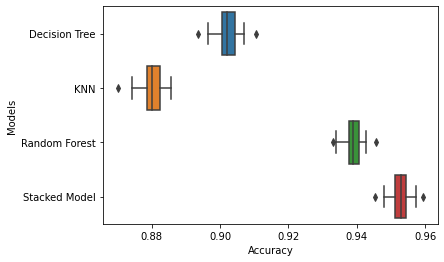

In [86]:
model_plot = sns.boxplot(data=results[:2] + results[4:], orient='h')
model_plot.yaxis.set_ticklabels(['Decision Tree', 'KNN',
                                 'Random Forest', 'Stacked Model'])

model_plot.set_ylabel('Models')
model_plot.set_xlabel('Accuracy')

model_plot.figure.savefig(plots_dir / 'model_plot', bbox_inches='tight')

## Fitting the model

In [17]:
stacked_model = models['rf']

stacked_model.fit(X_train, y_train)

RandomForestClassifier()

In [18]:
stacked_model.score(X_test, y_test)

0.8613419825663896

## Saving model for later use

In [ ]:
filename = 'prediction_model.pkl'
pickle.dump(stacked_model, open(filename, 'wb'))

Reopening model using pickle package.

In [ ]:
with open('prediction_model.pkl', 'rb') as model:
    prediction_model = pickle.load(model)